In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [5]:
file_dir = 'datasets/test_cleaned'
out_dir = 'datasets/test_forecast'
pattern = '*_cleaned.csv'
metrics_file = 'datasets/test_forecast/metrics_summary.csv'

os.makedirs(out_dir, exist_ok=True)

test_days = 7

files = glob.glob(os.path.join(file_dir, pattern))
print("Список файлов для обработки:", files)

Список файлов для обработки: ['datasets/test_cleaned\\GAZP_cleaned.csv']


In [12]:
f = 'datasets/test_cleaned/GAZP_cleaned.csv'

df = pd.read_csv(f, parse_dates=['Datetime'])
print("Первые строки после чтения CSV:")
df.head()
    

Первые строки после чтения CSV:


,Datetime,Open,High,Low,Close,Volume,Ticker,IsMissing,Rolling_Mean,Rolling_Std,Rolling_Median,Upper_Bound,Lower_Bound,IsOutlier,Close_Replaced,Close_Smoothed,Final_Close
0,2021-10-01 09:50:00,358.45,358.45,358.45,358.45,130460.0,GAZP,0,358.450000,NaN,358.450,NaN,NaN,0,358.45,358.450000,358.45
1,2021-10-01 10:00:00,358.45,360.26,357.29,359.79,4175250.0,GAZP,0,359.120000,0.947523,359.120,361.962569,356.277431,0,359.79,359.343333,359.79
2,2021-10-01 10:10:00,359.79,359.90,357.70,357.75,1690270.0,GAZP,0,358.663333,1.036597,358.450,361.773124,355.553542,0,357.75,358.432857,357.75
3,2021-10-01 10:20:00,357.80,358.16,357.30,358.08,1210420.0,GAZP,0,358.517500,0.895223,358.265,361.203170,355.831830,0,358.08,358.244667,358.08
4,2021-10-01 10:30:00,358.08,358.26,356.22,356.50,2015490.0,GAZP,0,358.114000,1.189592,358.080,361.682777,354.545223,0,356.50,357.344194,356.50


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162516 entries, 0 to 162515
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Datetime        162516 non-null  datetime64[ns]
 1   Open            61079 non-null   float64       
 2   High            61079 non-null   float64       
 3   Low             61079 non-null   float64       
 4   Close           61079 non-null   float64       
 5   Volume          61079 non-null   float64       
 6   Ticker          61079 non-null   object        
 7   IsMissing       162516 non-null  int64         
 8   Rolling_Mean    61079 non-null   float64       
 9   Rolling_Std     61078 non-null   float64       
 10  Rolling_Median  61079 non-null   float64       
 11  Upper_Bound     61078 non-null   float64       
 12  Lower_Bound     61078 non-null   float64       
 13  IsOutlier       162516 non-null  int64         
 14  Close_Replaced  61079 non-null   flo

In [18]:
df = df.sort_values('Datetime')
df = df[df['IsMissing'] == 0]
df = df.dropna(subset=['Final_Close'])
print("\nПосле фильтрации IsMissing=0 и удаления NaN:")
print("Количество строк после чистки:", len(df))
df.head()


После фильтрации IsMissing=0 и удаления NaN:
Количество строк после чистки: 61079


,Datetime,Open,High,Low,Close,Volume,Ticker,IsMissing,Rolling_Mean,Rolling_Std,Rolling_Median,Upper_Bound,Lower_Bound,IsOutlier,Close_Replaced,Close_Smoothed,Final_Close,Date
0,2021-10-01 09:50:00,358.45,358.45,358.45,358.45,130460.0,GAZP,0,358.450000,NaN,358.450,NaN,NaN,0,358.45,358.450000,358.45,2021-10-01
1,2021-10-01 10:00:00,358.45,360.26,357.29,359.79,4175250.0,GAZP,0,359.120000,0.947523,359.120,361.962569,356.277431,0,359.79,359.343333,359.79,2021-10-01
2,2021-10-01 10:10:00,359.79,359.90,357.70,357.75,1690270.0,GAZP,0,358.663333,1.036597,358.450,361.773124,355.553542,0,357.75,358.432857,357.75,2021-10-01
3,2021-10-01 10:20:00,357.80,358.16,357.30,358.08,1210420.0,GAZP,0,358.517500,0.895223,358.265,361.203170,355.831830,0,358.08,358.244667,358.08,2021-10-01
4,2021-10-01 10:30:00,358.08,358.26,356.22,356.50,2015490.0,GAZP,0,358.114000,1.189592,358.080,361.682777,354.545223,0,356.50,357.344194,356.50,2021-10-01


In [15]:
# Выделяем только дату
df['Date'] = df['Datetime'].dt.date
df['Date'] = pd.to_datetime(df['Date'])
print("\nПроверка Date-колонки (выделена из Datetime):")
df[['Datetime','Date']].head()


Проверка Date-колонки (выделена из Datetime):


,Datetime,Date
0,2021-10-01 09:50:00,2021-10-01
1,2021-10-01 10:00:00,2021-10-01
2,2021-10-01 10:10:00,2021-10-01
3,2021-10-01 10:20:00,2021-10-01
4,2021-10-01 10:30:00,2021-10-01


In [20]:
day_df = df.groupby('Date').agg({'Final_Close': 'mean'}).reset_index()
day_df = day_df.rename(columns={'Final_Close': 'Price'})
    
print("\nДанные после агрегации по дням:")
display(day_df.head())
display(day_df.describe())


Данные после агрегации по дням:


,Date,Price
0,2021-10-01,360.550000
1,2021-10-04,371.333855
2,2021-10-05,384.052048
3,2021-10-06,382.407229
4,2021-10-07,370.286937


,Date,Price
count,767,767.000000
mean,2023-04-30 23:26:12.359843584,194.563751
min,2021-10-01 00:00:00,113.925663
25%,2022-08-03 12:00:00,160.712892
50%,2023-05-05 00:00:00,168.250000
75%,2024-02-03 12:00:00,208.798920
max,2024-11-02 00:00:00,384.052048
std,NaN,67.230233


In [26]:
train_df = day_df.iloc[:-test_days].copy()
test_df  = day_df.iloc[-test_days:].copy()

train_df.tail()

,Date,Price
755,2024-10-18,135.812048
756,2024-10-21,135.791084
757,2024-10-22,136.592992
758,2024-10-23,135.835060
759,2024-10-24,133.758795


In [27]:
test_df

,Date,Price
760,2024-10-25,133.614578
761,2024-10-28,128.015830
762,2024-10-29,125.173253
763,2024-10-30,125.141807
764,2024-10-31,123.375301
765,2024-11-01,124.176265
766,2024-11-02,127.370120


In [28]:
    # Превращаем их в DatetimeIndex с freq='D'
    train_df = train_df.set_index('Date').asfreq('D')
    train_df['Price'] = train_df['Price'].interpolate(method='time')
    
    test_df = test_df.set_index('Date').asfreq('D')
    test_df['Price'] = test_df['Price'].interpolate(method='time')
    
    print("\ntrain_df после asfreq('D') и интерполяции:")
    display(train_df.head())
    display(train_df.tail())
    
    print("\ntest_df после asfreq('D') и интерполяции:")
    display(test_df)


train_df после asfreq('D') и интерполяции:


,Price
Date,
2021-10-01,360.550000
2021-10-02,364.144618
2021-10-03,367.739237
2021-10-04,371.333855
2021-10-05,384.052048


,Price
Date,
2024-10-20,135.798072
2024-10-21,135.791084
2024-10-22,136.592992
2024-10-23,135.835060
2024-10-24,133.758795



test_df после asfreq('D') и интерполяции:


,Price
Date,
2024-10-25,133.614578
2024-10-26,131.748329
2024-10-27,129.882079
2024-10-28,128.015830
2024-10-29,125.173253
2024-10-30,125.141807
2024-10-31,123.375301
2024-11-01,124.176265
2024-11-02,127.370120


In [ ]:
ses_preds = []
cur_ses = train_df['Price'].copy()
idx_ses = cur_ses.index[-1]
    
# пошаговый SES на 3 дня
for step in range(3):
    ses_model = SimpleExpSmoothing(cur_ses).fit(optimized=True)
    ses_f = ses_model.forecast(1).iloc[-1]
        
    ses_lo = ses_f * 0.95
    ses_hi = ses_f * 1.05
    ses_preds.append((ses_f, ses_lo, ses_hi))
        
    idx_ses += pd.Timedelta(days=1)
    cur_ses.loc[idx_ses] = ses_f
        
    print(f"День +{step+1}, SES прогноз={ses_f:.3f}, min={ses_lo:.3f}, max={ses_hi:.3f}")
    
cur_ses.tail(7)

День +1, SES прогноз=133.759, min=127.071, max=140.447
День +2, SES прогноз=133.759, min=127.071, max=140.447
День +3, SES прогноз=133.759, min=127.071, max=140.447


Date
2024-10-21    135.791084
2024-10-22    136.592992
2024-10-23    135.835060
2024-10-24    133.758795
2024-10-25    133.758795
2024-10-26    133.758795
2024-10-27    133.758795
Freq: D, Name: Price, dtype: float64

In [32]:
# Проверка стационарности ADF-тест
adf_res = adfuller(train_df['Price'])
print(f"p-value: {adf_res[1]:.5f}")
    
d_order = 0
diff_col = 'Price'
    
if adf_res[1] > 0.05:
    print("Нестационарна")
    train_df['Diff'] = train_df['Price'].diff()
    train_df = train_df.dropna(subset=['Diff'])
    diff_col = 'Diff'
    d_order = 1
else:
    print("Стационарна => d=0.")
    
best_aic = np.inf
best_order = None
    
# Подбираем (p, q)
for p_ in [1, 2]:
    for q_ in [1, 2]:
        try:
            tmp_model = ARIMA(train_df[diff_col], order=(p_, d_order, q_))
            tmp_res = tmp_model.fit()
            if tmp_res.aic < best_aic:
                best_aic = tmp_res.aic
                best_order = (p_, d_order, q_)
        except:
            pass
    
print(f"\nЛучший порядок (p,d,q) для ARIMA: {best_order}, AIC={best_aic:.2f}")

p-value: 0.05859
Нестационарна

Лучший порядок (p,d,q) для ARIMA: (1, 1, 2), AIC=6266.78


In [35]:
# Пошаговый прогноз ARIMA
ari_preds = []
# исходный ряд до теста и его дополняем
cur_ari = day_df.set_index('Date').iloc[:-test_days]['Price'].copy()
idx_ari = cur_ari.index[-1]

for step in range(3):
    ari_model = ARIMA(cur_ari, order=best_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
    ari_res = ari_model.fit()
    ari_f = ari_res.forecast(1).iloc[-1]
        
    ari_lo = ari_f * 0.95
    ari_hi = ari_f * 1.05
    ari_preds.append((ari_f, ari_lo, ari_hi))
        
    idx_ari += pd.Timedelta(days=1)
    cur_ari.loc[idx_ari] = ari_f
        
    print(f"День +{step+1}, ARIMA прогноз={ari_f:.3f}, min={ari_lo:.3f}, max={ari_hi:.3f}")
    
cur_ari.tail(7)

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

День +1, ARIMA прогноз=133.287, min=126.623, max=139.952
День +2, ARIMA прогноз=133.512, min=126.837, max=140.188
День +3, ARIMA прогноз=133.560, min=126.882, max=140.238


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2024-10-21    135.791084
2024-10-22    136.592992
2024-10-23    135.835060
2024-10-24    133.758795
2024-10-25    133.287186
2024-10-26    133.512195
2024-10-27    133.560321
Name: Price, dtype: float64

In [38]:
tkr = os.path.basename(f).split('_')[0]
print(f"\n{tkr} прогнозы")
print("SES:", [round(x[0], 3) for x in ses_preds])
print("ARIMA:", [round(x[0], 3) for x in ari_preds])


GAZP прогнозы
SES: [np.float64(133.759), np.float64(133.759), np.float64(133.759)]
ARIMA: [np.float64(133.287), np.float64(133.512), np.float64(133.56)]


In [41]:
test_3 = test_df['Price'][:3]
ses_vals_3 = [x[0] for x in ses_preds]
ari_vals_3 = [x[0] for x in ari_preds]

ses_mae = mean_absolute_error(test_3, ses_vals_3)
ses_mape = mean_absolute_percentage_error(test_3, ses_vals_3)
try:
    ses_r2 = r2_score(test_3, ses_vals_3)
except:
    ses_r2 = np.nan
    
ari_mae = mean_absolute_error(test_3, ari_vals_3)
ari_mape = mean_absolute_percentage_error(test_3, ari_vals_3)
try:
    ari_r2 = r2_score(test_3, ari_vals_3)
except:
    ari_r2 = np.nan
    
print(f"SES:   MAE={ses_mae:.3f}, MAPE={ses_mape:.3f}, R2={ses_r2:.3f}")
print(f"ARIMA: MAE={ari_mae:.3f}, MAPE={ari_mape:.3f}, R2={ari_r2:.3f}")
    

SES:   MAE=2.010, MAPE=0.015, R2=-1.741
ARIMA: MAE=1.923, MAPE=0.015, R2=-1.404


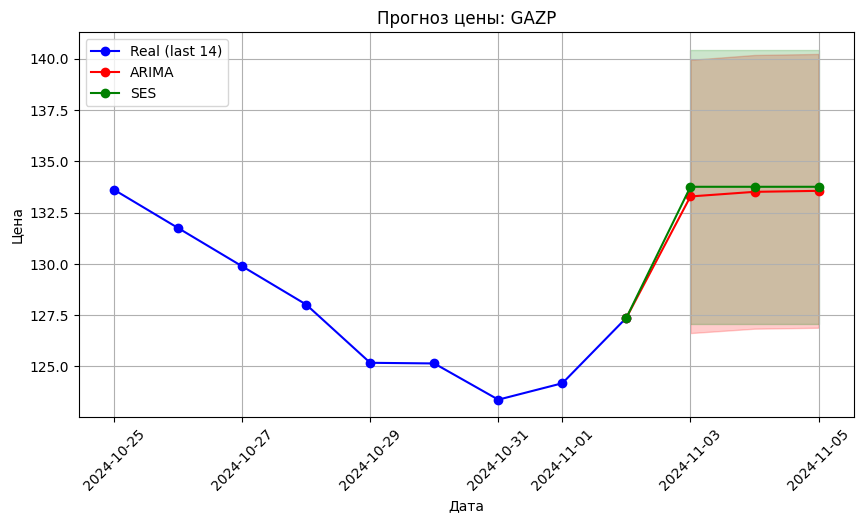

In [43]:
plt.figure(figsize=(10,5))
    
real_14 = test_df['Price'][-14:]
plt.plot(real_14.index, real_14.values, 
        label='Real (last 14)', marker='o', color='blue')
    
ar_dates = [real_14.index[-1] + pd.Timedelta(days=i+1) for i in range(3)]
ar_vals = [x[0] for x in ari_preds]
ar_lo = [x[1] for x in ari_preds]
ar_hi = [x[2] for x in ari_preds]
    
plt.plot([real_14.index[-1]] + ar_dates, 
        [real_14.values[-1]] + ar_vals, 
        marker='o', color='red', label='ARIMA')
plt.fill_between(ar_dates, ar_lo, ar_hi, color='red', alpha=0.2)
    
se_dates = [real_14.index[-1] + pd.Timedelta(days=i+1) for i in range(3)]
se_vals = [x[0] for x in ses_preds]
se_lo = [x[1] for x in ses_preds]
se_hi = [x[2] for x in ses_preds]
    
plt.plot([real_14.index[-1]] + se_dates, 
        [real_14.values[-1]] + se_vals, 
        marker='o', color='green', label='SES')
plt.fill_between(se_dates, se_lo, se_hi, color='green', alpha=0.2)
    
plt.title(f'Прогноз цены: {tkr}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()